In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../data/final_dataset.csv')
df.head()

,Fillings,Fraud
0,nanitem 14 exhibits financial statements repor...,yes
1,item 14 principal accounting fees services mat...,no
2,item 14 exhibits financial statements schedule...,yes
3,item 14 exhibits financial statement schedules...,yes
4,item 14 exhibits financial statement schedules...,no


In [4]:
# Dataset overview: structure, types, memory, and samples
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

print("Shape:", df.shape)
print("\nData types:")
print(df.dtypes)

print("\nMemory usage (MB):")
print(df.memory_usage(deep=True).sum() / (1024 ** 2))

print("\nNumber of unique values per column (first 30):")
print(df.nunique(dropna=False).sort_values(ascending=False).head(30))

print("\nSample rows:")
df.sample(min(5, len(df)), random_state=42)

print("\nBasic describe (numeric):")
df.describe().T

print("\nBasic describe (all):")
df.describe(include="all").T


Shape: (170, 2)

Data types:
Fillings    object
Fraud       object
dtype: object

Memory usage (MB):
409.5816478729248

Number of unique values per column (first 30):
Fillings    170
Fraud         2
dtype: int64

Sample rows:

Basic describe (numeric):

Basic describe (all):


,count,unique,top,freq
Fillings,170,170,nanitem 14 exhibits financial statements repor...,1
Fraud,170,2,yes,85


Target column candidates: ['Fraud']
Selected target: Fraud

Class counts:
Fraud
yes    85
no     85
Name: count, dtype: int64

Class percentages (%):
Fraud
yes    50.0
no     50.0
Name: count, dtype: float64


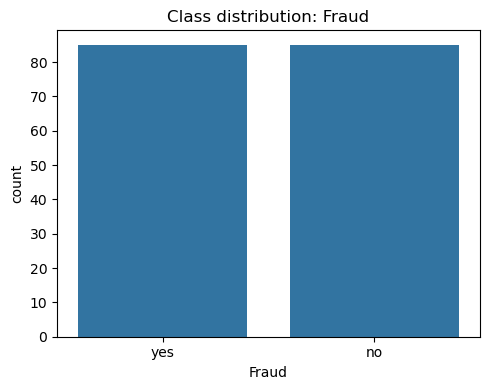

In [5]:
# Target / class distribution
from collections import Counter

# Heuristic target detection
column_name_candidates = [
    "fraud", "is_fraud", "label", "target", "class", "fraud_flag", "fraudulent",
]

possible_targets = []
for col in df.columns:
    normalized = col.lower().strip()
    if normalized in column_name_candidates:
        possible_targets.append(col)

# Also consider low-cardinality boolean/binary columns as candidates
low_cardinality = [c for c in df.columns if df[c].nunique(dropna=True) <= 3]
possible_targets = list(dict.fromkeys(possible_targets + low_cardinality))

print("Target column candidates:", possible_targets)

selected_target = None
for c in possible_targets:
    unique_vals = sorted(df[c].dropna().unique())
    if len(unique_vals) == 2 or set(unique_vals).issubset({0,1}):
        selected_target = c
        break

if selected_target is None and len(possible_targets) > 0:
    selected_target = possible_targets[0]

print("Selected target:", selected_target)

if selected_target is not None:
    value_counts = df[selected_target].value_counts(dropna=False)
    print("\nClass counts:")
    print(value_counts)
    print("\nClass percentages (%):")
    print((value_counts / len(df) * 100).round(3))

    plt.figure(figsize=(5,4))
    sns.countplot(data=df, x=selected_target)
    plt.title(f"Class distribution: {selected_target}")
    plt.tight_layout()
    plt.show()
else:
    print("No clear binary/categorical target detected. Please set `selected_target` manually.")


Detected text-like columns: ['Fillings']


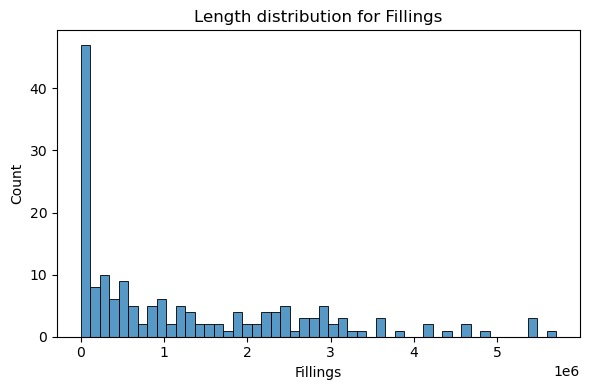

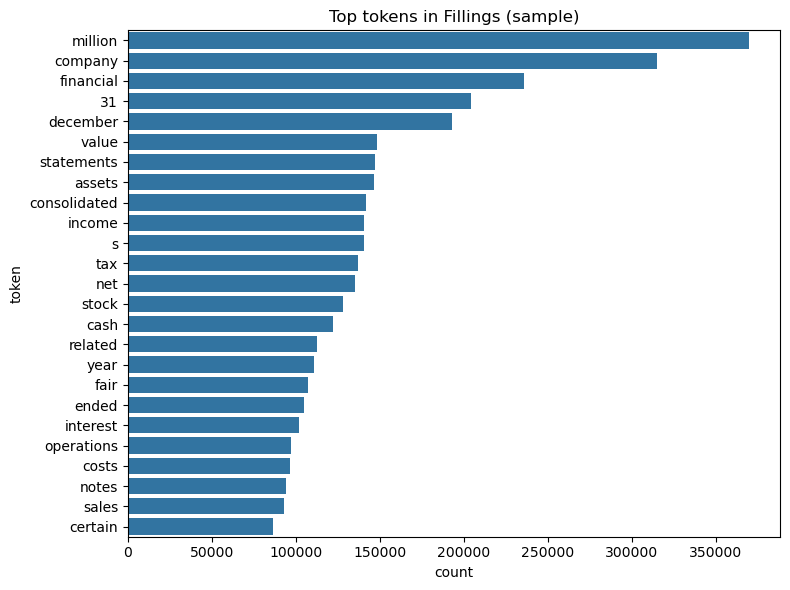

In [8]:
# Text fields exploration (if any)
text_like_cols = []
for c in df.select_dtypes(include=["object"]).columns:
    sample_vals = df[c].dropna().astype(str).head(1000)
    if len(sample_vals) == 0:
        continue
    avg_len = sample_vals.str.len().mean()
    has_spaces_ratio = (sample_vals.str.contains(" ").mean())
    if avg_len > 15 or has_spaces_ratio > 0.3:
        text_like_cols.append(c)

print("Detected text-like columns:", text_like_cols)

for c in text_like_cols:
    lengths = df[c].dropna().astype(str).str.len()
    plt.figure(figsize=(6,4))
    sns.histplot(lengths, bins=50)
    plt.title(f"Length distribution for {c}")
    plt.tight_layout()
    plt.show()

    # Simple token frequency (lowercased, alphanum tokens)
    sample_texts = df[c].dropna().astype(str).sample(min(20000, len(df)), random_state=42)
    import re
    tokens = []
    for t in sample_texts:
        tokens.extend(re.findall(r"[a-zA-Z0-9_]+", t.lower()))
    from collections import Counter
    common_tokens = Counter(tokens).most_common(25)
    tok_df = pd.DataFrame(common_tokens, columns=["token", "count"])    
    plt.figure(figsize=(8,6))
    sns.barplot(data=tok_df, x="count", y="token", orient="h")
    plt.title(f"Top tokens in {c} (sample)")
    plt.tight_layout()
    plt.show()


Chars  mean=1277849.3, median=692204, max=5708964
Words  mean=161000.2, median=86087, max=712629


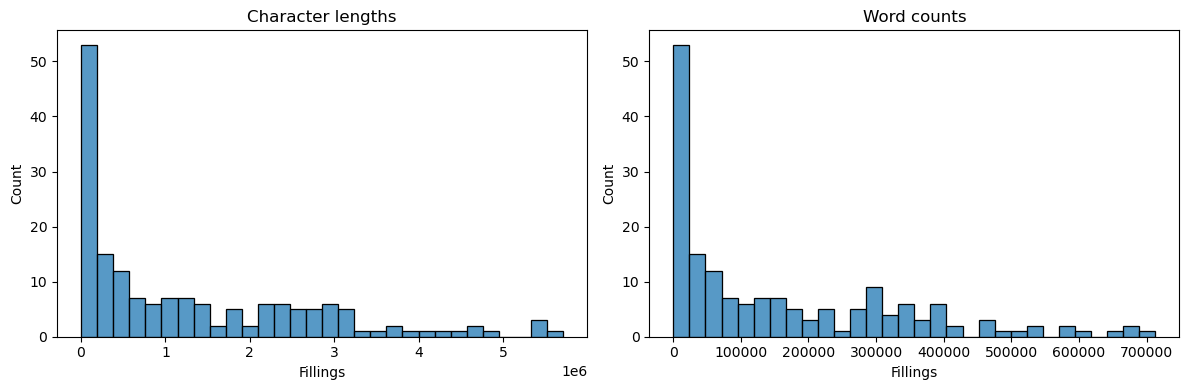

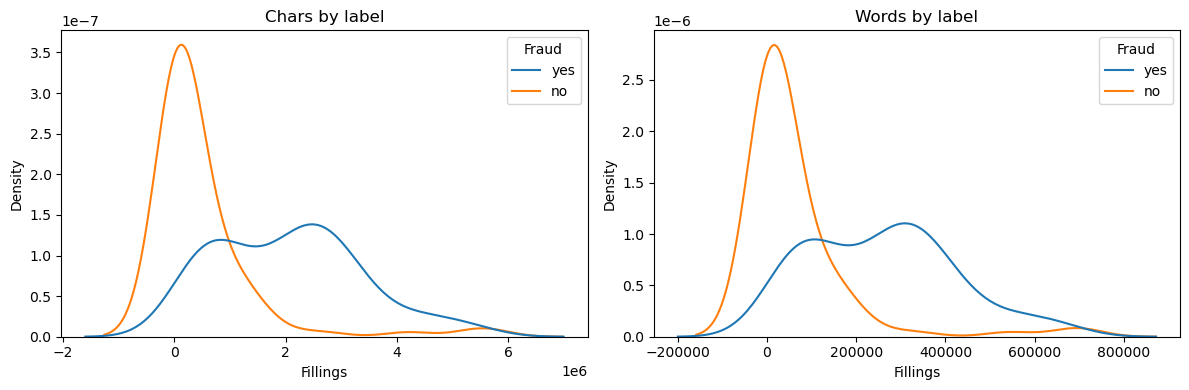

In [10]:
# NLP EDA for `Fillings`
import re
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

text_col = "Fillings"
label_col = "Fraud" if "Fraud" in df.columns else None

def tokenize(s):
    return re.findall(r"[a-zA-Z0-9']+", str(s).lower())

def remove_stop(words, extra_stop=None):
    stops = set(ENGLISH_STOP_WORDS)
    if extra_stop:
        stops |= set(extra_stop)
    return [w for w in words if w not in stops]

# Length distributions
char_len = df[text_col].astype(str).str.len()
word_len = df[text_col].astype(str).apply(lambda x: len(tokenize(x)))

print(f"Chars  mean={char_len.mean():.1f}, median={char_len.median():.0f}, max={char_len.max():.0f}")
print(f"Words  mean={word_len.mean():.1f}, median={word_len.median():.0f}, max={word_len.max():.0f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(char_len, bins=30); plt.title("Character lengths")
plt.subplot(1,2,2); sns.histplot(word_len, bins=30); plt.title("Word counts")
plt.tight_layout(); plt.show()

# By class (if available)
if label_col:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); sns.kdeplot(x=char_len, hue=df[label_col]); plt.title("Chars by label")
    plt.subplot(1,2,2); sns.kdeplot(x=word_len, hue=df[label_col]); plt.title("Words by label")
    plt.tight_layout(); plt.show()

In [11]:
def top_ngrams(series, n=1, k=20, extra_stop=None):
    cnt = Counter()
    for s in series.astype(str):
        toks = remove_stop(tokenize(s), extra_stop=extra_stop)
        if n == 1:
            grams = toks
        else:
            grams = [" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)]
        cnt.update(grams)
    return pd.DataFrame(cnt.most_common(k), columns=["ngram","count"])

extra_stop = {"https", "http", "com", "www"}
print("Top unigrams overall:")
display(top_ngrams(df[text_col], n=1, k=25, extra_stop=extra_stop))

print("Top bigrams overall:")
display(top_ngrams(df[text_col], n=2, k=25, extra_stop=extra_stop))

if label_col:
    for v in df[label_col].unique():
        print(f"\nTop unigrams for {label_col}={v}:")
        display(top_ngrams(df.loc[df[label_col]==v, text_col], n=1, k=20, extra_stop=extra_stop))

Top unigrams overall:


,ngram,count
0,million,369916
1,company,315271
2,financial,236224
3,31,204535
4,december,193080
5,value,148372
6,statements,147021
7,assets,146662
8,consolidated,141910
9,income,140718


Top bigrams overall:


,ngram,count
0,december 31,160335
1,financial statements,112770
2,fair value,92496
3,consolidated financial,77102
4,company s,69289
5,ended december,68645
6,year ended,55510
7,common stock,42828
8,notes consolidated,39546
9,cash flows,37656



Top unigrams for Fraud=yes:


,ngram,count
0,million,309499
1,company,261753
2,financial,189049
3,31,163450
4,december,155041
5,value,120048
6,assets,118846
7,tax,115802
8,consolidated,115634
9,statements,114792



Top unigrams for Fraud=no:


,ngram,count
0,million,60417
1,company,53518
2,financial,47175
3,31,41085
4,december,38039
5,statements,32229
6,stock,28839
7,income,28697
8,value,28324
9,assets,27816


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    token_pattern=r"[A-Za-z0-9']+",
    stop_words='english',
    max_features=3000
)
X = tfidf.fit_transform(df[text_col].astype(str))
vocab = np.array(tfidf.get_feature_names_out())

# Overall top mean TF-IDF terms
mean_tfidf = np.asarray(X.mean(axis=0)).ravel()
top_idx = mean_tfidf.argsort()[::-1][:25]
pd.DataFrame({"term": vocab[top_idx], "mean_tfidf": mean_tfidf[top_idx]})

,term,mean_tfidf
0,company,0.193209
1,million,0.170009
2,financial,0.140464
3,31,0.113096
4,december,0.106313
5,statements,0.089211
6,stock,0.080021
7,income,0.077928
8,consolidated,0.076781
9,s,0.075659


In [ ]:
if label_col:
    out = {}
    for v in df[label_col].unique():
        rows = (df[label_col] == v).values.nonzero()[0]
        cls_mean = np.asarray(X[rows].mean(axis=0)).ravel()
        top_idx = cls_mean.argsort()[::-1][:20]
        out[str(v)] = pd.DataFrame({"term": vocab[top_idx], "mean_tfidf": cls_mean[top_idx]})
    out  # displays dict of dataframes